In [1]:
#import sys
#sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy import linalg

#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
# the physics-guided neural network Inverse Problem

class PhysicsInformedNN_IP():
    #def __init__(self, X_u, u, X_f, layers, lb, ub):
    def __init__(self, x,t, Y_obs,layers, alpha):
        
        # boundary conditions
        #self.loss_function = torch.nn.MSELoss(reduction ='mean')
        self.alpha = torch.nn.Parameter(torch.tensor(alpha, requires_grad=True).float().to(device))
        #self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(x, requires_grad=True).float().to(device)
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.Y_obs = torch.tensor(Y_obs).float().to(device)
        #self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter("alpha", self.alpha)

        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=0.5, 
            max_iter=50000, 
            max_eval=None, 
            tolerance_grad=1e-11, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_tt + u_xx + self.alpha*u-(x+1)*(x-1)-(t+1)*(t-1)-3*(x+1)*(x-1)*(t+1)*(t-1)-(6-10*torch.pi*torch.pi)*torch.sin(torch.pi*x)*torch.sin(3*torch.pi*t) 
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)

        loss_u = torch.mean((self.Y_obs - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Alpha: %.5f' % (self.iter, loss.item(), loss_u.item(), loss_f.item(),self.alpha.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [4]:
N_u = 100
mu = 0
std = 1

layers = [2,30,30,30,1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['x'].flatten()[:,None]
x = data['x'].flatten()[:,None]

X, T = np.meshgrid(x,t)

Exact = 0.5*(X + 1)*(X-1)*(T+1)*(T-1) + np.sin(np.pi*X)*np.sin(3*np.pi*T) 

Y_obs = Exact.flatten()[:,None]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

total_points=len(x)*len(t)


idx = np.random.choice(total_points, N_u, replace=False)

X_star_train = X_star[idx,:]
Y_obs_train = Y_obs[idx,:] 


Y_obs_train = Y_obs_train + np.random.normal(mu, std, size = Y_obs_train.shape)

x_train = X_star_train[:,0:1]
t_train = X_star_train[:,1:2]

In [5]:
model = PhysicsInformedNN_IP(x_train, t_train, Y_obs_train, layers, 4.)


In [6]:
model.train()


Iter 100, Loss: 2.32341e+02, Loss_u: 1.64021e+01, Loss_f: 2.15939e+02, Alpha: 10.74114
Iter 200, Loss: 6.87216e+01, Loss_u: 1.47863e+01, Loss_f: 5.39354e+01, Alpha: 11.87195
Iter 300, Loss: 3.19862e+01, Loss_u: 1.28473e+01, Loss_f: 1.91390e+01, Alpha: 12.47437
Iter 400, Loss: 1.91934e+01, Loss_u: 8.59909e+00, Loss_f: 1.05943e+01, Alpha: 12.89665
Iter 500, Loss: 1.06985e+01, Loss_u: 5.94801e+00, Loss_f: 4.75046e+00, Alpha: 13.20878
Iter 600, Loss: 7.30013e+00, Loss_u: 4.43291e+00, Loss_f: 2.86722e+00, Alpha: 13.26037
Iter 700, Loss: 4.53338e+00, Loss_u: 3.45728e+00, Loss_f: 1.07610e+00, Alpha: 13.42447
Iter 800, Loss: 3.57288e+00, Loss_u: 3.06559e+00, Loss_f: 5.07292e-01, Alpha: 13.60449
Iter 900, Loss: 3.09985e+00, Loss_u: 2.91942e+00, Loss_f: 1.80428e-01, Alpha: 13.64915
Iter 1000, Loss: 2.72370e+00, Loss_u: 2.55403e+00, Loss_f: 1.69668e-01, Alpha: 13.84630
Iter 1100, Loss: 2.40331e+00, Loss_u: 2.26407e+00, Loss_f: 1.39244e-01, Alpha: 13.87702
Iter 1200, Loss: 2.13057e+00, Loss_u: 1.9

In [7]:
u_pred, f_pred = model.predict(X_star)
#u_star = Exact.flatten()[:,None]

#error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

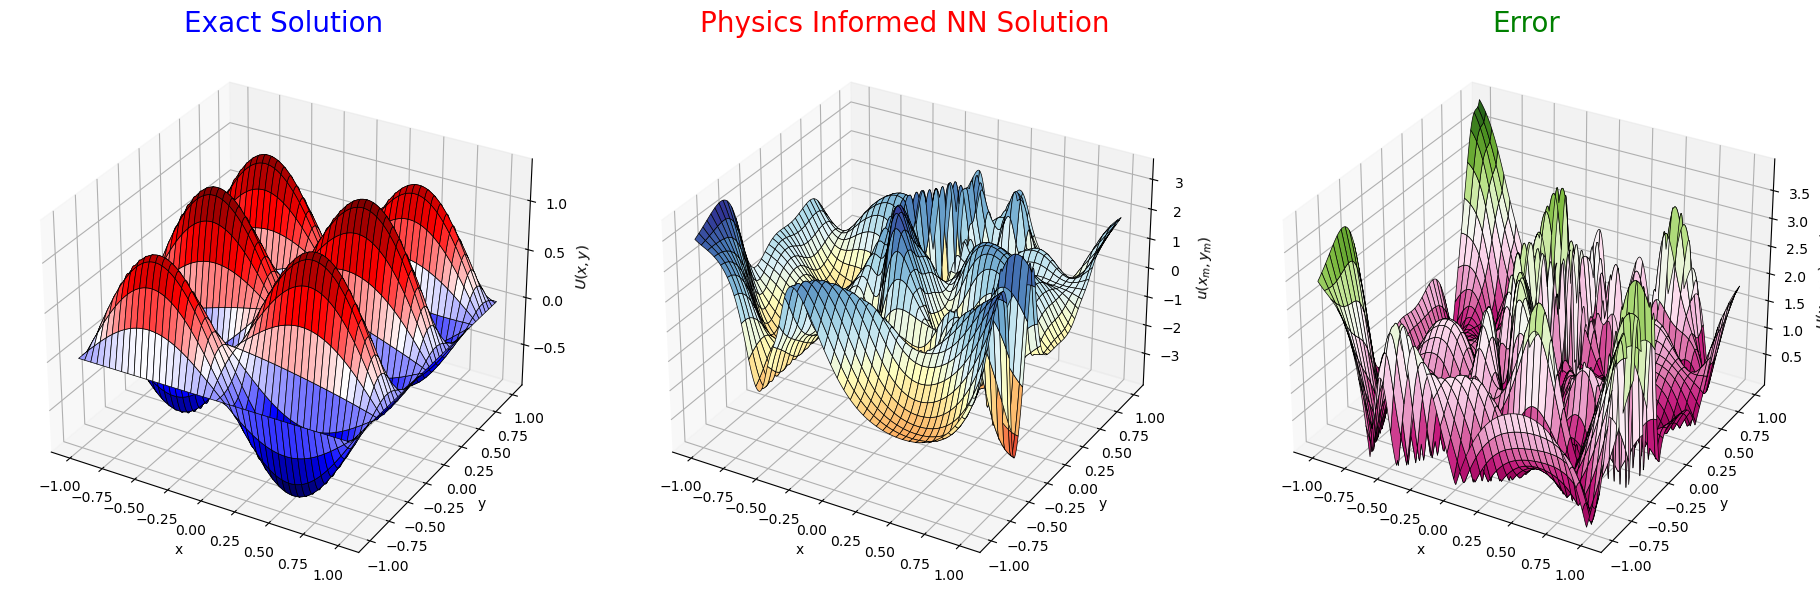

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm



# Plotting
fig = plt.figure(figsize=(25,12))



ax = fig.add_subplot(211, projection='3d')

ax.set_title("Physics Informed NN Solution", fontsize=20,color="red")

ax.plot_surface(X, T, U_pred, cmap=cm.RdYlBu, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$u(x_{m},y_{m})$",fontsize = 10)


ax = fig.add_subplot(221, projection='3d')

ax.set_title("Exact Solution", fontsize=20,color="blue")

ax.plot_surface(X, T, Exact, cmap=cm.seismic, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$U(x,y)$",fontsize = 10)



ax = fig.add_subplot(222, projection='3d')

ax.set_title("Error", fontsize=20,color="green")

ax.plot_surface(X, T, Error, cmap=cm.PiYG, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$U(x_{m},y_{m}) - u(x,y)$",fontsize = 10)


plt.tight_layout()
plt.show()

In [9]:
nPoints = [10,50,100,150,200,500,1000,2000]
mean_er = np.zeros(len(nPoints))
mean_alpha = np.zeros(len(nPoints))

iters = 10

for i,Nu in enumerate(nPoints):
    er = np.zeros(iters)
    alpha = np.zeros(iters)

    for j in range(iters):

        idx = np.random.choice(total_points, Nu, replace=False)

        X_star_train = X_star[idx,:]
        Y_obs_train = Y_obs[idx,:] 

        #Y_obs_train = Y_obs_train + np.random.normal(mu, std, size = Y_obs_train.shape)

        x_train = X_star_train[:,0:1]
        t_train = X_star_train[:,1:2]

        model = PhysicsInformedNN_IP(x_train, t_train, Y_obs_train, layers, 4.)

        model.train()

        u_pred, f_pred = model.predict(X_star)                  

        U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

        er[j] = np.linalg.norm(Exact - U_pred)
        alpha[j] = model.alpha.item()

    mean_er[i] = np.nanmean(er)
    mean_alpha[i] = np.nanmean(alpha)

Iter 100, Loss: 6.03935e+00, Loss_u: 5.72850e+00, Loss_f: 3.10848e-01, Alpha: 6.69651
Iter 200, Loss: 2.41316e+00, Loss_u: 2.35313e+00, Loss_f: 6.00324e-02, Alpha: 8.09001
Iter 300, Loss: 6.38552e-01, Loss_u: 5.94582e-01, Loss_f: 4.39697e-02, Alpha: 9.16060
Iter 400, Loss: 2.07402e-01, Loss_u: 2.06924e-01, Loss_f: 4.77570e-04, Alpha: 9.27888
Iter 500, Loss: 5.55693e-02, Loss_u: 5.44982e-02, Loss_f: 1.07109e-03, Alpha: 8.78041
Iter 600, Loss: 7.42523e-03, Loss_u: 7.37908e-03, Loss_f: 4.61480e-05, Alpha: 8.48181
Iter 700, Loss: 1.34061e-03, Loss_u: 1.27402e-03, Loss_f: 6.65906e-05, Alpha: 8.41222
Iter 800, Loss: 9.72213e-06, Loss_u: 9.71589e-06, Loss_f: 6.23874e-09, Alpha: 8.38175
Iter 100, Loss: 1.61977e+02, Loss_u: 4.05036e+01, Loss_f: 1.21474e+02, Alpha: 7.32223
Iter 200, Loss: 4.61805e+00, Loss_u: 4.55689e+00, Loss_f: 6.11579e-02, Alpha: 14.81293
Iter 300, Loss: 1.40351e+00, Loss_u: 1.39504e+00, Loss_f: 8.46399e-03, Alpha: 15.39409
Iter 400, Loss: 5.37071e-01, Loss_u: 5.28523e-01, Lo

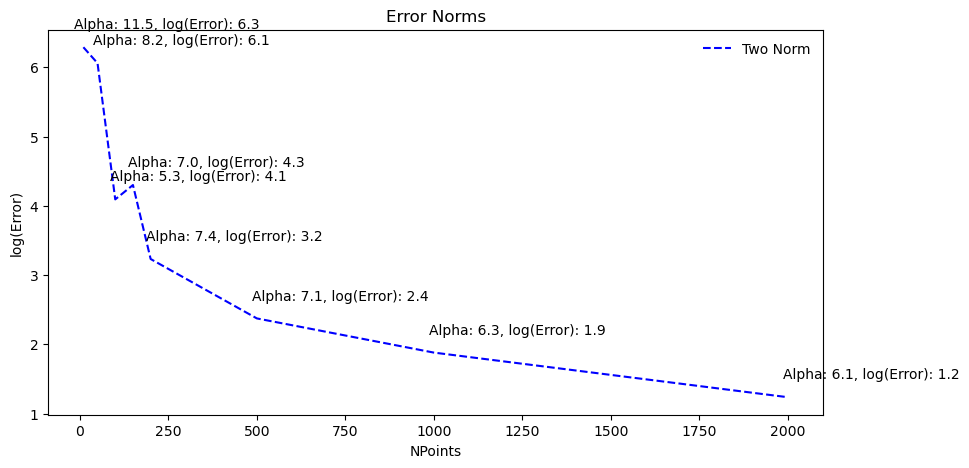

In [10]:
# Plotting both errors as function of M
fig = plt.figure(figsize=[10,5])

#####################
plt.title("Error Norms")

# Plot the error norm with their values
plt.plot(nPoints,np.log(mean_er),label = "Two Norm",color="blue", linestyle="--")

for x,y,z in zip(nPoints,mean_alpha,mean_er):
    plt.annotate(f"Alpha: {y:0.1f}, log(Error): {np.log(z):0.1f}\n\n",(x,np.log(z)),textcoords="offset points",xytext=(60,-10),ha='center')


plt.xlabel("NPoints")
plt.ylabel("log(Error)")


plt.legend(frameon = False)
plt.show()